In [1]:
# %load COVID19_data_visualization_and_forecast.py
"""
Created on Fri Apr  3 17:48:45 2020

@author: User
"""

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib 
import sys
import  chart_story_parameters as cspp
import algo as algo
%matplotlib inline  

In [2]:

def load_and_prep_data(file_address,verbose=False):
    """
    

    Parameters
    ----------
    file_address : TYPE
        DESCRIPTION.
    verbose : TYPE, optional
        DESCRIPTION. The default is False.

    Returns
    -------
    df : TYPE
        DESCRIPTION.

    """

    df_org = pd.read_csv(file_address)
    df_org.head()
    df=df_org[['dateRep','cases','deaths','countryterritoryCode','countriesAndTerritories','popData2018']].copy()
   
    #insert record for world counts
    world_pop=df[['countriesAndTerritories','popData2018']].drop_duplicates()['popData2018'].sum()
    table = pd.pivot_table(df[['dateRep','cases','deaths','countriesAndTerritories']], index=['dateRep', 'countriesAndTerritories']).copy()    
    table=table.sort_index(ascending=False)
    record_world=table.groupby(by='dateRep',level=0,axis=0).sum()
    record_world=record_world.reset_index()
    record_world=record_world.sort_index(ascending=False)
    record_world=record_world.reset_index(drop=True)
    record_world['popData2018']=world_pop
    record_world['countryterritoryCode']='WORLD'
    record_world['countriesAndTerritories']='WORLD'
    record_world = record_world[['dateRep', 'cases', 'deaths', 'countryterritoryCode','countriesAndTerritories', 'popData2018']]
    
    df=df.append(record_world,ignore_index=True)
    df['dateRep']= pd.to_datetime(df['dateRep']) 
    df=df.set_index('dateRep')
    return df
    

def gen_country_stats(df,cnt_code,covidcase_type,day_thr,mawindow):
    """
    

    Parameters
    ----------
    df : TYPE
        DESCRIPTION.
    cnt_code : TYPE
        DESCRIPTION.
    covidcase_type : TYPE
        DESCRIPTION.
    day_thr : TYPE
        DESCRIPTION.
    mawindow : TYPE
        DESCRIPTION.

    Returns
    -------
    cntAdf : TYPE
        DESCRIPTION.
    country_name : TYPE
        DESCRIPTION.

    """
    cntAdf=df[df.countryterritoryCode==cnt_code].copy()
    cntAdf=cntAdf.sort_index()
    cntAdf.columns = ['cases.'+cnt_code,'deaths.'+cnt_code,'countryterritoryCode.'+cnt_code,'countriesAndTerritories.'+cnt_code,'popData2018.'+cnt_code]
    cntAdf['total_cases.'+cnt_code]=cntAdf['cases.'+cnt_code].cumsum()
    cntAdf['total_deaths.'+cnt_code]=cntAdf['deaths.'+cnt_code].cumsum()
    cntAdf['cases(MovAvg).'+cnt_code]=cntAdf['cases.'+cnt_code].rolling(mawindow).mean()
    cntAdf['deaths(MovAvg).'+cnt_code]=cntAdf['deaths.'+cnt_code].rolling(mawindow).mean()
    cntAdf['cases(MovAvg)perPop1M.'+cnt_code]=cntAdf['cases(MovAvg).'+cnt_code]*1e6/cntAdf['popData2018.'+cnt_code]
    cntAdf['deaths(MovAvg)perPop1M.'+cnt_code]=cntAdf['deaths(MovAvg).'+cnt_code]*1e6/cntAdf['popData2018.'+cnt_code]
    cntAdf['total_casesperPop1M.'+cnt_code]=cntAdf['total_cases.'+cnt_code]*1e6/cntAdf['popData2018.'+cnt_code]
    cntAdf['total_deathsperPop1M.'+cnt_code]=cntAdf['total_deaths.'+cnt_code]*1e6/cntAdf['popData2018.'+cnt_code]
    cntAdf['casesperPop1M.'+cnt_code]=cntAdf['cases.'+cnt_code]*1e6/cntAdf['popData2018.'+cnt_code]
    cntAdf['deathsperPop1M.'+cnt_code]=cntAdf['deaths.'+cnt_code]*1e6/cntAdf['popData2018.'+cnt_code]
    cntAdf=cntAdf.dropna()
    #cntAdf['cases(MovAvg).'+cnt_code]=np.log1p(cntAdf['cases(MovAvg).'+cnt_code])
    cntAdf=cntAdf[cntAdf[covidcase_type+cnt_code]>day_thr].reset_index()
    country_name=cntAdf['countriesAndTerritories.'+cnt_code][0]
    return cntAdf,country_name

In [3]:
def RUNcoviddatastory(selected_story_name,PubDate,country_list,day_thr,mawindow,fdays,loga=False,forecast_flag=False,forecast_mdl_list=['hwes'],plot_figures_flag=False,save_figures_flag=True,verbose=False,show_mdl_detail=False): 
    """
    

    Parameters
    ----------
    selected_story_name : TYPE
        DESCRIPTION.
    PubDate : TYPE
        DESCRIPTION.
    country_list : TYPE
        DESCRIPTION.
    day_thr : TYPE
        DESCRIPTION.
    mawindow : TYPE
        DESCRIPTION.
    fdays : TYPE
        DESCRIPTION.
    loga : TYPE, optional
        DESCRIPTION. The default is False.
    forecast_flag : TYPE, optional
        DESCRIPTION. The default is False.
    forecast_mdl_list : TYPE, optional
        DESCRIPTION. The default is ['hwes'].
    plot_figures_flag : TYPE, optional
        DESCRIPTION. The default is False.
    save_figures_flag : TYPE, optional
        DESCRIPTION. The default is True.
    verbose : TYPE, optional
        DESCRIPTION. The default is False.
    show_mdl_detail : TYPE, optional
        DESCRIPTION. The default is False.

    Returns
    -------
    new_dict : TYPE
        DESCRIPTION.

    """
    np.set_printoptions(precision=2)
    np.random.seed(25)
    cspp.set_plt_conf(plt)
    sb.set_style('whitegrid')
    file_address='./data/'+'COVID-19-geographic-disbtribution-worldwide-'+PubDate+'.csv'
    
    Chart_Story_df=cspp.gen_chart_story_params_dict(forecast_flag,mawindow, fdays,day_thr)
    selected_story=Chart_Story_df[selected_story_name]  
    df=load_and_prep_data(file_address,verbose)

    covidcase_type=selected_story['covidcase_type']
    FIGylabel_text=selected_story['FIGylabel_text']
    FIGxlabel_text=selected_story['FIGxlabel_text']
    Chart_title=selected_story['Chart_title']
    INFOtext=selected_story['INFOtext'] 
    new_dict={}
    pred_dic={}
    fig, ax = plt.subplots(figsize=(8, 8))
    for cntA in country_list:
        dfc=df[(df.countryterritoryCode==cntA)]
        dfc=df.sort_index()
        cntAdf,country=gen_country_stats(dfc,cntA,covidcase_type,day_thr,mawindow)
        new_dict[cntA]=cntAdf
    for cntA,mdl_name in zip(country_list,forecast_mdl_list):
        df_s=new_dict[cntA]
        markers_on=df_s.shape[0]*[False]
        markers_on[-1]=True #last point in the series
        predictor_column=covidcase_type+cntA
        forecast_mdl=mdl_name
        if forecast_flag==True:
            if forecast_mdl=='hwes':
                forecast_res=algo.utility_hwes_predict(df_s[predictor_column].dropna(),fdays,loga,show_mdl_detail=show_mdl_detail)
            elif forecast_mdl=='sarimax':
                forecast_res=algo.utility_sarimax_predict(df_s[predictor_column].dropna(),fdays,loga,plot_figures_flag=plot_figures_flag,show_mdl_detail=show_mdl_detail)
            forecast_res=forecast_res.astype(int)
                #datetime index
            startdate=pd.to_datetime(PubDate).date()
            enddate=startdate+pd.Timedelta(forecast_res.shape[0]-1,unit='D')
            forecast_with_date=forecast_res.copy()
            didx = pd.date_range(start=startdate,end=enddate,freq ='D')
            forecast_with_date.index=didx
            if verbose==True:
                print(cntA)
                print(selected_story_name)
                print(forecast_with_date)
        country_nameA=df_s['countriesAndTerritories.'+cntA][0]
        ax.plot(df_s.index,df_s[predictor_column],label=''+country_nameA,markersize=15,marker='.',markevery=markers_on)
        if forecast_flag==True:
            ax.plot(forecast_res.index,forecast_res,label='_nolegend_',ls='--',color=plt.gca().lines[-1].get_color())
    #ax.set_yscale('log')        
    ax.legend(loc='upper left')
    ax.set_ylabel(FIGylabel_text,fontsize=cspp.BIGGER_SIZE)
    ax.set_xlabel(FIGxlabel_text,fontsize=cspp.BIGGER_SIZE)
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.annotate(INFOtext, (0,0), (0, -55), xycoords='axes fraction', textcoords='offset points', va='top',fontsize=10,fontstyle='italic',color='gray') 
    ax.set_title("COVID-19 "+Chart_title+" by Country\n"+' '+'as of '+PubDate+' 6:00-10:00 CET' ,fontsize=cspp.BIGGER_SIZE)
    fig.tight_layout()
    if save_figures_flag==True:
        figtitletosave='./figures/' + selected_story_name + '.png'      
        if verbose==True:
            #print("\nsaving figures to the local figures folder:\n"+figtitletosave+"\n")
            pass
        fig.savefig(figtitletosave,dpi=300)
 
    new_df=pd.DataFrame() 
    for cntA in country_list:
        s=new_dict[cntA]
        predictor_column=covidcase_type+cntA
        s=s[predictor_column]
        new_df=pd.concat((new_df,s),axis=1)

    return new_dict
    


In [4]:
# Country selection codes:
       #  'AFG', 'ALB', 'AND', 'DZA', 'AGO', nan, 'ATG', 'ARG', 'ARM', 'ABW',
       # 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL',
       # 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BIH', 'BWA', 'BRA', 'VGB',
       # 'BRN', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN', 'CPV', 'CYM',
       # 'CAF', 'TCD', 'CHL', 'CHN', 'COL', 'COG', 'CRI', 'CIV', 'HRV',
       # 'CUB', 'CUW', 'CYP', 'CZE', 'COD', 'DNK', 'DJI', 'DMA', 'DOM',
       # 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FRO',
       # 'FJI', 'FIN', 'FRA', 'PYF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA',
       # 'GIB', 'GRC', 'GRL', 'GRD', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB',
       # 'GUY', 'HTI', 'VAT', 'HND', 'HUN', 'ISL', 'IND', 'IDN', 'IRN',
       # 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR',
       # 'KAZ', 'KEN', 'XKX', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LBR',
       # 'LBY', 'LIE', 'LTU', 'LUX', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI',
       # 'MLT', 'MRT', 'MUS', 'MEX', 'MDA', 'MCO', 'MNG', 'MNE', 'MSR',
       # 'MAR', 'MOZ', 'MMR', 'NAM', 'NPL', 'NLD', 'NCL', 'NZL', 'NIC',
       # 'NER', 'NGA', 'MKD', 'MNP', 'NOR', 'OMN', 'PAK', 'PSE', 'PAN',
       # 'PNG', 'PRY', 'PER', 'PHL', 'POL', 'PRT', 'PRI', 'QAT', 'ROU',
       # 'RUS', 'RWA', 'KNA', 'LCA', 'VCT', 'SMR', 'SAU', 'SEN', 'SRB',
       # 'SYC', 'SLE', 'SGP', 'SXM', 'SVK', 'SVN', 'SOM', 'ZAF', 'KOR',
       # 'ESP', 'LKA', 'SDN', 'SUR', 'SWE', 'CHE', 'SYR', 'TWN', 'THA',
       # 'TLS', 'TGO', 'TTO', 'TUN', 'TUR', 'TCA', 'UGA', 'UKR', 'ARE',
       # 'GBR', 'TZA', 'USA', 'VIR', 'URY', 'UZB', 'VEN', 'VNM', 'ZMB',
       # 'ZWE','WORLD'    
      
# chart story selection list:
        # 'Total_cases'
        # 'Total_deaths'
        # 'Daily_cases'
        # 'Daily_deaths'
        # 'Daily_cases_MovAvg'
        # 'Daily_deaths_MovAvg'
        # 'Daily_cases_MovAvg_perPopulation'
        # 'Daily_deaths_MovAvg_perPopulation'
        #'Total_cases_perPopulation'
        #'Total_deaths_perPopulation'
        #'Daily_cases_perPopulation'
        #'Daily_deaths_perPopulation'
PubDate='2020-04-13' # pubdate of the data file by European Centre for Disease Prevention and Control
# original data link: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
forecast_flag=True  
forecast_mdl=['hwes','hwes','sarimax','hwes'] #options are ['hwes','sarimax']
loga=False #take log of data
plot_figures_flag=True
save_figures_flag=True
verbose=True
show_mdl_detail=False
mawindow=3 #moving average window size for smoothing charts
fdays=3 # number of steps forecasts (forward  time points) 
case_thr=10 # the day threshold that the first N cases recorded
deat_thr=3 # the day threshold that the first N deaths recorded
caseperpop_thr=0
deatperpop_thr=0
country_list=['ITA','DEU','GBR','USA']
 

ITA
Total_cases
2020-04-13    160565
2020-04-14    164880
2020-04-15    169311
Freq: D, Name: hwes_model, dtype: int32
DEU
Total_cases
2020-04-13    125938
2020-04-14    128931
2020-04-15    131994
Freq: D, Name: hwes_model, dtype: int32
GBR
Total_cases
2020-04-13     90142
2020-04-14     95906
2020-04-15    101569
Freq: D, Name: sarimax_model, dtype: int32
USA
Total_cases
2020-04-13    586630
2020-04-14    617203
2020-04-15    649370
Freq: D, Name: hwes_model, dtype: int32


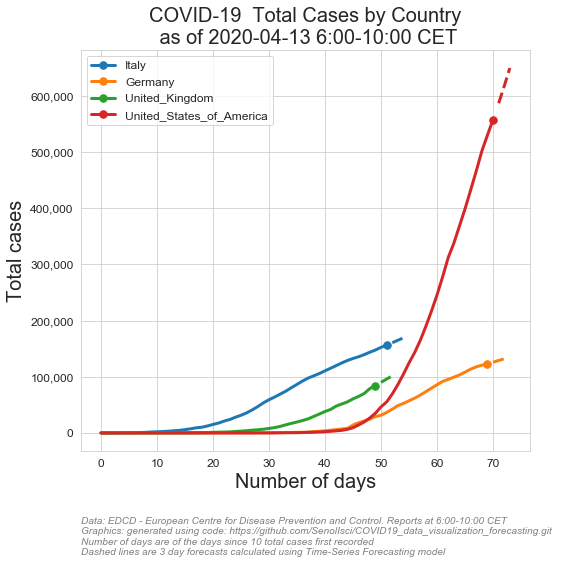

In [5]:
new_dict1=RUNcoviddatastory('Total_cases',PubDate,country_list,case_thr,mawindow,fdays,loga,forecast_flag,forecast_mdl,plot_figures_flag,save_figures_flag,verbose,show_mdl_detail)        

ITA
Total_deaths
2020-04-13    20398
2020-04-14    20888
2020-04-15    21390
Freq: D, Name: hwes_model, dtype: int32
DEU
Total_deaths
2020-04-13    2934
2020-04-14    3075
2020-04-15    3223
Freq: D, Name: hwes_model, dtype: int32
GBR
Total_deaths
2020-04-13    11355
2020-04-14    12063
2020-04-15    12737
Freq: D, Name: sarimax_model, dtype: int32
USA
Total_deaths
2020-04-13    23717
2020-04-14    25443
2020-04-15    27295
Freq: D, Name: hwes_model, dtype: int32


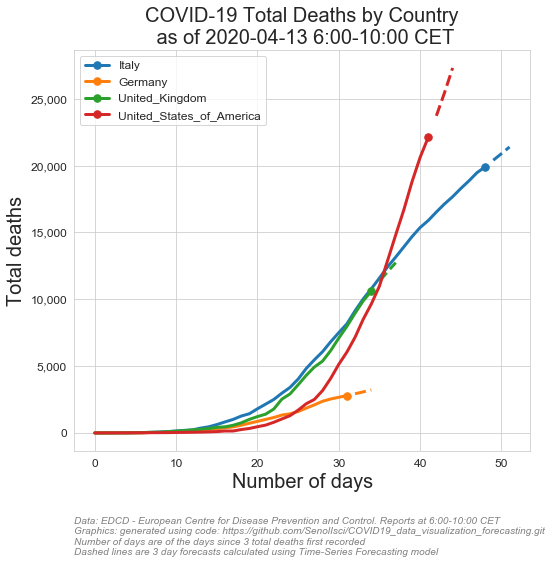

In [6]:
new_dict1=RUNcoviddatastory('Total_deaths',PubDate,country_list,deat_thr,mawindow,fdays,loga,forecast_flag,forecast_mdl,plot_figures_flag,save_figures_flag,verbose,show_mdl_detail)        


ITA
Total_cases_perPopulation
2020-04-13    2656
2020-04-14    2728
2020-04-15    2801
Freq: D, Name: hwes_model, dtype: int32
DEU
Total_cases_perPopulation
2020-04-13    1518
2020-04-14    1554
2020-04-15    1590
Freq: D, Name: hwes_model, dtype: int32
GBR
Total_cases_perPopulation
2020-04-13    1385
2020-04-14    1495
2020-04-15    1602
Freq: D, Name: sarimax_model, dtype: int32
USA
Total_cases_perPopulation
2020-04-13    1793
2020-04-14    1886
2020-04-15    1984
Freq: D, Name: hwes_model, dtype: int32


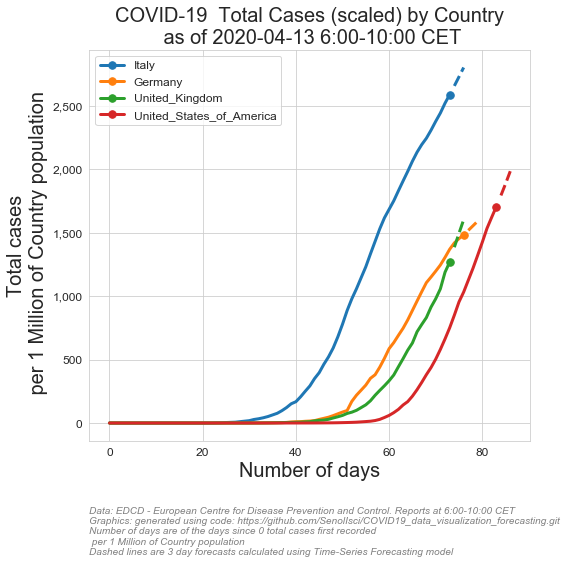

In [7]:
new_dict1=RUNcoviddatastory('Total_cases_perPopulation',PubDate,country_list,caseperpop_thr,mawindow,fdays,loga,forecast_flag,forecast_mdl,plot_figures_flag,save_figures_flag,verbose,show_mdl_detail)        


ITA
Total_deaths_perPopulation
2020-04-13    337
2020-04-14    345
2020-04-15    354
Freq: D, Name: hwes_model, dtype: int32
DEU
Total_deaths_perPopulation
2020-04-13    35
2020-04-14    37
2020-04-15    38
Freq: D, Name: hwes_model, dtype: int32
GBR
Total_deaths_perPopulation
2020-04-13    170
2020-04-14    181
2020-04-15    191
Freq: D, Name: sarimax_model, dtype: int32
USA
Total_deaths_perPopulation
2020-04-13    72
2020-04-14    77
2020-04-15    83
Freq: D, Name: hwes_model, dtype: int32


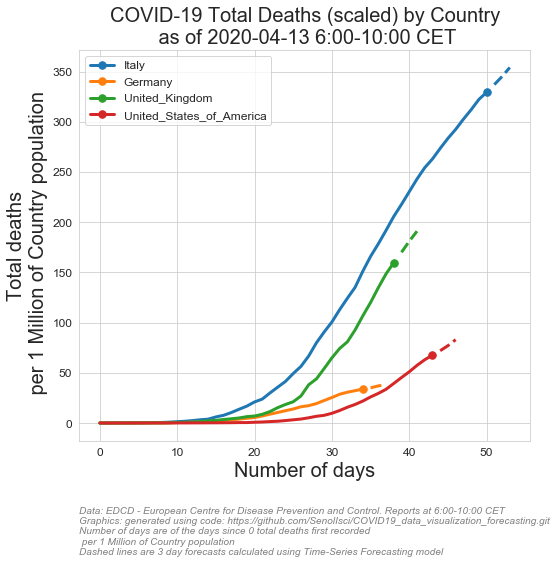

In [8]:
new_dict1=RUNcoviddatastory('Total_deaths_perPopulation',PubDate,country_list,deatperpop_thr,mawindow,fdays,loga,forecast_flag,forecast_mdl,plot_figures_flag,save_figures_flag,verbose,show_mdl_detail)        


ITA
Daily_cases
2020-04-13    4304
2020-04-14    4366
2020-04-15    4429
Freq: D, Name: hwes_model, dtype: int32
DEU
Daily_cases
2020-04-13    3428
2020-04-14    3202
2020-04-15    2991
Freq: D, Name: hwes_model, dtype: int32
GBR
Daily_cases
2020-04-13    7712
2020-04-14    7154
2020-04-15    7079
Freq: D, Name: sarimax_model, dtype: int32
USA
Daily_cases
2020-04-13    26760
2020-04-14    25430
2020-04-15    24167
Freq: D, Name: hwes_model, dtype: int32


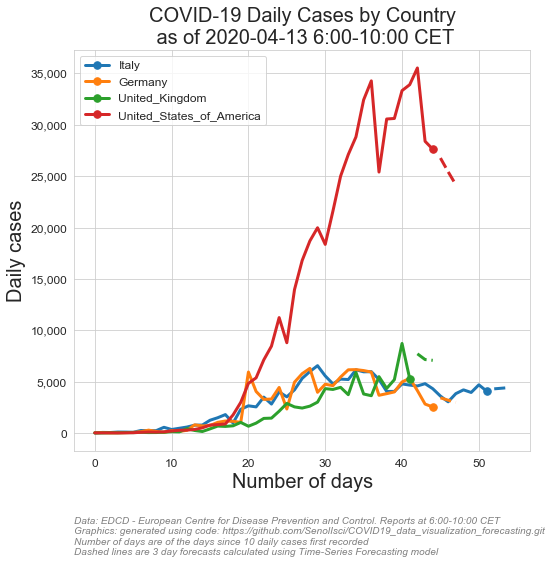

In [9]:
new_dict1=RUNcoviddatastory('Daily_cases',PubDate,country_list,case_thr,mawindow,fdays,loga,forecast_flag,forecast_mdl,plot_figures_flag,save_figures_flag,verbose,show_mdl_detail)        


ITA
Daily_deaths
2020-04-13    497
2020-04-14    480
2020-04-15    463
Freq: D, Name: hwes_model, dtype: int32
DEU
Daily_deaths
2020-04-13    123
2020-04-14    120
2020-04-15    117
Freq: D, Name: hwes_model, dtype: int32
GBR
Daily_deaths
2020-04-13    778
2020-04-14    766
2020-04-15    754
Freq: D, Name: sarimax_model, dtype: int32
USA
Daily_deaths
2020-04-13    1532
2020-04-14    1565
2020-04-15    1599
Freq: D, Name: hwes_model, dtype: int32


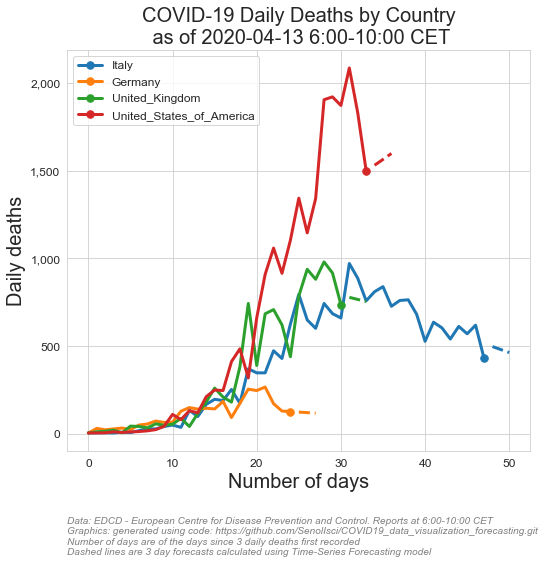

In [10]:
new_dict1=RUNcoviddatastory('Daily_deaths',PubDate,country_list,deat_thr,mawindow,fdays,loga,forecast_flag,forecast_mdl,plot_figures_flag,save_figures_flag,verbose,show_mdl_detail)        


ITA
Daily_cases_perPopulation
2020-04-13    71
2020-04-14    72
2020-04-15    73
Freq: D, Name: hwes_model, dtype: int32
DEU
Daily_cases_perPopulation
2020-04-13    33
2020-04-14    31
2020-04-15    28
Freq: D, Name: hwes_model, dtype: int32
GBR
Daily_cases_perPopulation
2020-04-13     76
2020-04-14    120
2020-04-15     82
Freq: D, Name: sarimax_model, dtype: int32
USA
Daily_cases_perPopulation
2020-04-13    86
2020-04-14    88
2020-04-15    90
Freq: D, Name: hwes_model, dtype: int32


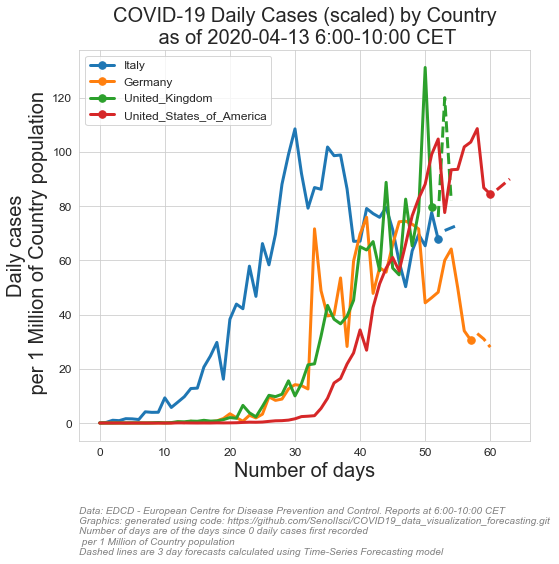

In [11]:
new_dict1=RUNcoviddatastory('Daily_cases_perPopulation',PubDate,country_list,caseperpop_thr,mawindow,fdays,loga,forecast_flag,forecast_mdl,plot_figures_flag,save_figures_flag,verbose,show_mdl_detail)        


ITA
Daily_deaths_perPopulation
2020-04-13    8
2020-04-14    7
2020-04-15    7
Freq: D, Name: hwes_model, dtype: int32
DEU
Daily_deaths_perPopulation
2020-04-13    1
2020-04-14    1
2020-04-15    1
Freq: D, Name: hwes_model, dtype: int32
GBR
Daily_deaths_perPopulation
2020-04-13    11
2020-04-14    11
2020-04-15    11
Freq: D, Name: sarimax_model, dtype: int32
USA
Daily_deaths_perPopulation
2020-04-13    4
2020-04-14    4
2020-04-15    4
Freq: D, Name: hwes_model, dtype: int32


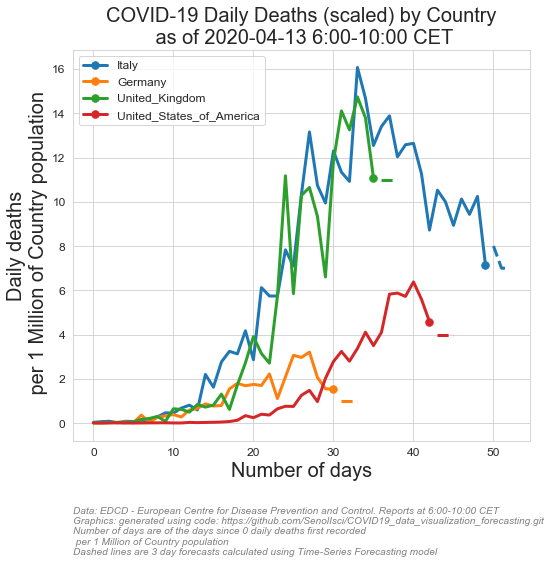

In [12]:
new_dict1=RUNcoviddatastory('Daily_deaths_perPopulation',PubDate,country_list,deatperpop_thr,mawindow,fdays,loga,forecast_flag,forecast_mdl,plot_figures_flag,save_figures_flag,verbose,show_mdl_detail)        


ITA
Daily_cases_MovAvg
2020-04-13    4208
2020-04-14    4172
2020-04-15    4135
Freq: D, Name: hwes_model, dtype: int32
DEU
Daily_cases_MovAvg
2020-04-13    2894
2020-04-14    2648
2020-04-15    2422
Freq: D, Name: hwes_model, dtype: int32
GBR
Daily_cases_MovAvg
2020-04-13    6784
2020-04-14    6615
2020-04-15    6572
Freq: D, Name: sarimax_model, dtype: int32
USA
Daily_cases_MovAvg
2020-04-13    28806
2020-04-14    27194
2020-04-15    25673
Freq: D, Name: hwes_model, dtype: int32


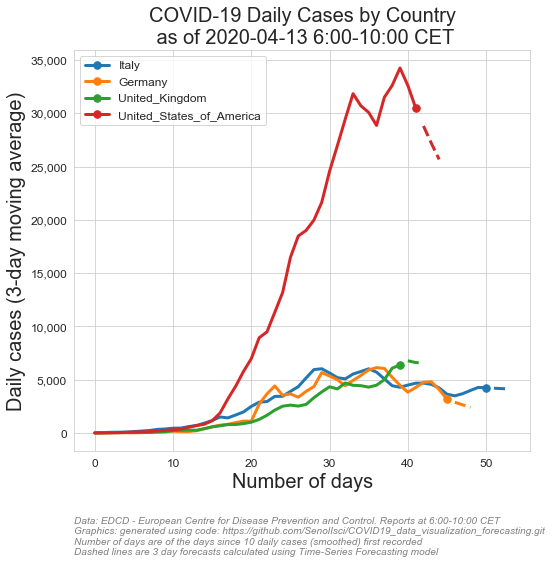

In [13]:
new_dict1=RUNcoviddatastory('Daily_cases_MovAvg',PubDate,country_list,case_thr,mawindow,fdays,loga,forecast_flag,forecast_mdl,plot_figures_flag,save_figures_flag,verbose,show_mdl_detail)        


ITA
Daily_deaths_MovAvg
2020-04-13    506
2020-04-14    475
2020-04-15    445
Freq: D, Name: hwes_model, dtype: int32
DEU
Daily_deaths_MovAvg
2020-04-13    106
2020-04-14     80
2020-04-15     60
Freq: D, Name: hwes_model, dtype: int32
GBR
Daily_deaths_MovAvg
2020-04-13    839
2020-04-14    802
2020-04-15    801
Freq: D, Name: sarimax_model, dtype: int32
USA
Daily_deaths_MovAvg
2020-04-13    1689
2020-04-14    1580
2020-04-15    1479
Freq: D, Name: hwes_model, dtype: int32


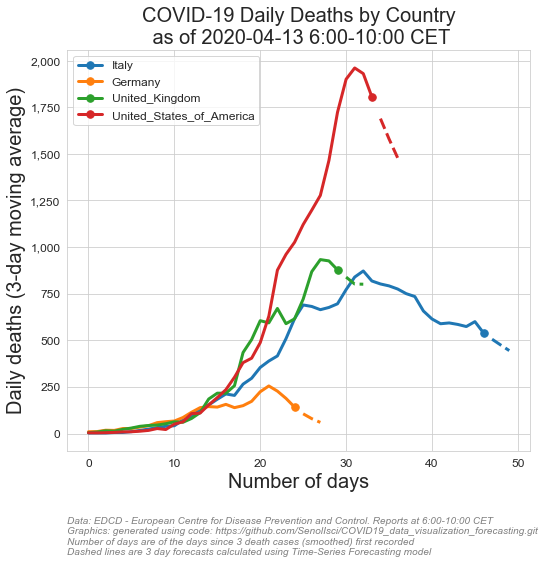

In [14]:
new_dict1=RUNcoviddatastory('Daily_deaths_MovAvg',PubDate,country_list,deat_thr,mawindow,fdays,loga,forecast_flag,forecast_mdl,plot_figures_flag,save_figures_flag,verbose,show_mdl_detail)        


ITA
Daily_cases_MovAvg_perPopulation
2020-04-13    69
2020-04-14    69
2020-04-15    68
Freq: D, Name: hwes_model, dtype: int32
DEU
Daily_cases_MovAvg_perPopulation
2020-04-13    34
2020-04-14    31
2020-04-15    28
Freq: D, Name: hwes_model, dtype: int32
GBR
Daily_cases_MovAvg_perPopulation
2020-04-13    102
2020-04-14    100
2020-04-15     99
Freq: D, Name: sarimax_model, dtype: int32
USA
Daily_cases_MovAvg_perPopulation
2020-04-13    88
2020-04-14    83
2020-04-15    78
Freq: D, Name: hwes_model, dtype: int32


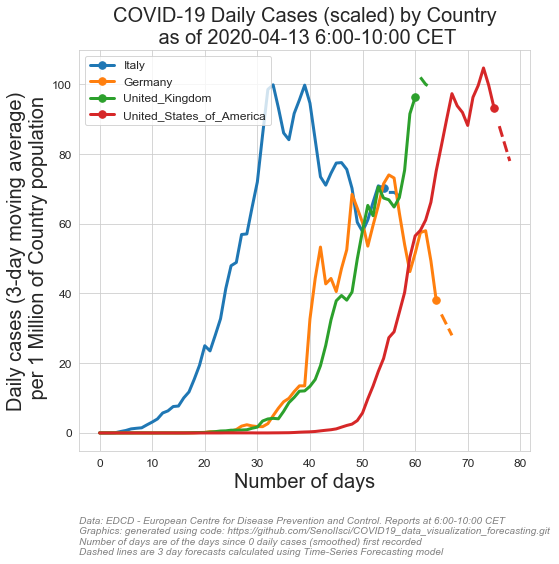

In [15]:
new_dict1=RUNcoviddatastory('Daily_cases_MovAvg_perPopulation',PubDate,country_list,caseperpop_thr,mawindow,fdays,loga,forecast_flag,forecast_mdl,plot_figures_flag,save_figures_flag,verbose,show_mdl_detail)        


ITA
Daily_deaths_MovAvg_perPopulation
2020-04-13    8
2020-04-14    7
2020-04-15    7
Freq: D, Name: hwes_model, dtype: int32
DEU
Daily_deaths_MovAvg_perPopulation
2020-04-13    1
2020-04-14    1
2020-04-15    1
Freq: D, Name: hwes_model, dtype: int32
GBR
Daily_deaths_MovAvg_perPopulation
2020-04-13    12
2020-04-14    12
2020-04-15    12
Freq: D, Name: sarimax_model, dtype: int32
USA
Daily_deaths_MovAvg_perPopulation
2020-04-13    5
2020-04-14    4
2020-04-15    4
Freq: D, Name: hwes_model, dtype: int32


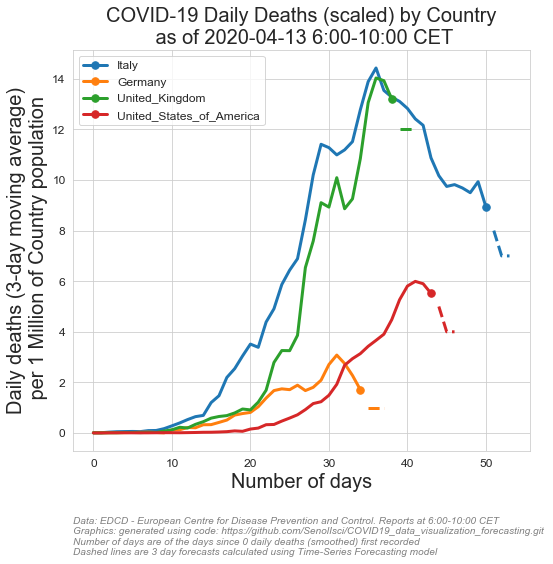

In [16]:
new_dict1=RUNcoviddatastory('Daily_deaths_MovAvg_perPopulation',PubDate,country_list,deatperpop_thr,mawindow,fdays,loga,forecast_flag,forecast_mdl,plot_figures_flag,save_figures_flag,verbose,show_mdl_detail)        